In [1]:
from scipy.io import wavfile

(source_clean_fs, source_clean_data) = wavfile.read('./data/source_clean.wav')
(plini_clean_fs, plini_clean_data) = wavfile.read('./data/plini_clean.wav')
(source_noise_fs, source_noise_data) = wavfile.read('./data/source_noise.wav')
(plini_noise_fs, plini_noise_data) = wavfile.read('./data/plini_noise.wav')

In [2]:
import pandas as pd

In [3]:
source_clean_df = pd.DataFrame(source_clean_data, columns=['L', 'R'])
source_clean_df.head()

,L,R
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [4]:
plini_clean_df = pd.DataFrame(plini_clean_data, columns=['L', 'R'])
plini_clean_df.head()

,L,R
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [5]:
source_noise_df = pd.DataFrame(source_noise_data, columns=['L', 'R'])
source_noise_df.head()

,L,R
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [6]:
plini_noise_df = pd.DataFrame(plini_noise_data, columns=['L', 'R'])
plini_noise_df.head()

,L,R
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [7]:
plini_clean_df['L'].max(), plini_noise_df['L'].max()

(32767, 29669)

In [10]:
2 ** 15

32768

In [11]:
MAX_VALUE = 2 ** 15 - 1
MAX_VALUE

32767

In [12]:
len(plini_clean_df), len(source_clean_df)

(2442240, 2442240)

In [13]:
len(plini_noise_df), len(source_noise_df)

(814464, 814464)

In [14]:
CLEAN_START_END = int(len(plini_clean_df) * 0.8)
CLEAN_START_END

1953792

In [15]:
NOISE_START_END = int(len(plini_noise_df) * 0.8)
NOISE_START_END

651571

In [16]:
(X_train_c_start, X_train_c_end) = (0, CLEAN_START_END)
(X_test_c_start, X_test_c_end) = (CLEAN_START_END, len(source_clean_df))
(y_train_c_start, y_train_c_end) = (0, CLEAN_START_END)
(y_test_c_start, y_test_c_end) = (CLEAN_START_END, len(plini_clean_df))

In [17]:
(X_train_n_start, X_train_n_end) = (0, NOISE_START_END)
(X_test_n_start, X_test_n_end) = (NOISE_START_END, len(source_noise_df))
(y_train_n_start, y_train_n_end) = (0, NOISE_START_END)
(y_test_n_start, y_test_n_end) = (NOISE_START_END, len(plini_noise_df))

## IT'S MONO

In [18]:
X_train_c_raw = source_clean_df['L'][X_train_c_start:X_train_c_end]
len(X_train_c_raw)

1953792

In [19]:
X_test_c_raw = source_clean_df['L'][X_test_c_start:X_test_c_end]
len(X_test_c_raw)

488448

In [20]:
y_train_c_raw = plini_clean_df['L'][y_train_c_start:y_train_c_end]
len(y_train_c_raw)

1953792

In [21]:
y_test_c_raw = plini_clean_df['L'][y_test_c_start:y_test_c_end]
len(y_test_c_raw)

488448

In [22]:
X_train_n_raw = source_noise_df['L'][X_train_n_start:X_train_n_end]
len(X_train_n_raw)

651571

In [23]:
X_test_n_raw = source_noise_df['L'][X_test_n_start:X_test_n_end]
len(X_test_n_raw)

162893

In [24]:
y_train_n_raw = plini_noise_df['L'][y_train_n_start:y_train_n_end]
len(y_train_n_raw)

651571

In [25]:
y_test_n_raw = plini_noise_df['L'][y_test_n_start:y_test_n_end]
len(y_test_n_raw)

162893

In [26]:
TR_C_N_DEV = source_clean_fs
TR_C_OFFSET_DEV = source_clean_fs * 2

TE_C_N_DEV = int(source_clean_fs / 8)
TE_C_OFFSET_DEV = source_clean_fs * 2

In [27]:
TR_N_N_DEV = source_noise_fs
TR_N_OFFSET_DEV = source_noise_fs * 2

TE_N_N_DEV = int(TE_C_N_DEV / 10)
TE_N_OFFSET_DEV = source_noise_fs * 2

In [28]:
(TR_C_N_DEV, TE_C_N_DEV, TR_N_N_DEV, TE_N_N_DEV)

(44100, 5512, 44100, 551)

In [29]:
X_train_c = X_train_c_raw[TR_C_OFFSET_DEV:TR_C_OFFSET_DEV+TR_C_N_DEV]
len(X_train_c)

44100

In [30]:
X_test_c = X_test_c_raw[TE_C_OFFSET_DEV:TE_C_OFFSET_DEV+TE_C_N_DEV]
len(X_test_c)

5512

In [31]:
y_train_c = y_train_c_raw[TR_C_OFFSET_DEV:TR_C_OFFSET_DEV+TR_C_N_DEV]
len(y_train_c)

44100

In [32]:
y_test_c = y_test_c_raw[TE_C_OFFSET_DEV:TE_C_OFFSET_DEV+TE_C_N_DEV]
len(y_test_c)

5512

In [33]:
X_train_n = X_train_n_raw[TR_N_OFFSET_DEV:TR_N_OFFSET_DEV+TR_N_N_DEV]
len(X_train_n)

44100

In [34]:
X_test_n = X_test_n_raw[TE_N_OFFSET_DEV:TE_N_OFFSET_DEV+TE_N_N_DEV]
len(X_test_n)

551

In [35]:
y_train_n = y_train_n_raw[TR_N_OFFSET_DEV:TR_N_OFFSET_DEV+TR_N_N_DEV]
len(y_train_n)

44100

In [36]:
y_test_n = y_test_n_raw[TE_N_OFFSET_DEV:TE_N_OFFSET_DEV+TE_N_N_DEV]
len(y_test_n)

551

In [37]:
X_test_c.iloc[:10]

2041992    153
2041993    147
2041994    154
2041995    176
2041996    215
2041997    279
2041998    358
2041999    443
2042000    539
2042001    625
Name: L, dtype: int16

In [38]:
# safe-checking data

## Preparing data for processing

In [39]:
X_train = (
    list(X_train_c) +
    list(X_train_n)
)

X_train[0], X_train[-1]

(-725, -14)

In [40]:
X_test = (
    list(X_test_c) +
    list(X_test_n)
)

X_test[0], X_test[-1]

(153, -16)

In [41]:
y_train = (
    list(y_train_c) +
    list(y_train_n)
)

y_train[0], y_train[-1]

(1118, 2083)

In [42]:
y_test = (
    list(y_test_c) +
    list(y_test_n)
)

y_test[0], y_test[-1]

(1572, -5526)

In [43]:
# import numpy as np

# train_shuffle_index = np.arange(0, len(X_train))
# np.random.shuffle(train_shuffle_index)

# test_shuffle_index = np.arange(0, len(X_test))
# np.random.shuffle(test_shuffle_index)

# X_train = np.array(X_train)[train_shuffle_index]
# y_train = np.array(y_train)[train_shuffle_index]

# X_test = np.array(X_test)[test_shuffle_index]
# y_test = np.array(y_test)[test_shuffle_index]

# X_train[0], y_train[0], len(X_train), len(y_train), len(X_test), len(y_test)

In [44]:
def normalize_keeping_mean(arr, forced_abs=None):
    left_abs = np.abs(arr.mean() - arr.min())
    right_abs = np.abs(arr.max() - arr.mean())
    
    n = max(left_abs, right_abs)
    
    if (forced_abs is not None):
        n = forced_abs
    
    return np.clip(arr / n, -1.0, 1.0)

In [45]:
def normalize(arr, forced_abs=None, mean=None):
    left_abs = np.abs(arr.mean() - arr.min())
    right_abs = np.abs(arr.max() - arr.mean())
    
    n = max(left_abs, right_abs)
    
    if (forced_abs is not None):
        n = forced_abs
        
    if (mean is None):
        mean = arr.mean()
    
    
    return np.clip((arr - mean) / n, -1.0, 1.0)

In [46]:
import numpy as np

X_tr = np.array(list(map(lambda x: np.array(x), X_train)))
X_tr_n = normalize(X_tr, forced_abs=MAX_VALUE, mean=0.0)
X_tr_n.min(), X_tr_n.max(), np.mean(X_tr_n)

(-0.07431257057405316, 0.09094515823847163, 2.90527905855173e-05)

In [47]:
import numpy as np

X_te = np.array(list(map(lambda x: np.array(x), X_test)))
X_te_n= normalize(X_te, forced_abs=MAX_VALUE, mean=0.0)
X_te_n.min(), X_te_n.max(), np.mean(X_te_n)

(-0.05261391033661916, 0.04519791253395184, -4.166282416837024e-05)

In [48]:

X_te_n.min(), X_te_n.max(), np.mean(X_te_n)

(-0.05261391033661916, 0.04519791253395184, -4.166282416837024e-05)

In [49]:
y_tr = np.array(list(map(lambda x: np.array(x), y_train)))
y_tr_n = normalize_keeping_mean(y_tr, forced_abs=MAX_VALUE)
y_tr_n.min(), y_tr_n.max(), np.mean(y_tr_n)

(-0.6644795068208869, 0.7200231940672017, -1.485580142678525e-05)

In [50]:
y_te = np.array(list(map(lambda x: np.array(x), y_test)))
y_te_n = normalize_keeping_mean(y_te, forced_abs=MAX_VALUE)
y_te_n.min(), y_te_n.max(), np.mean(y_te_n)

(-0.5569322794274728, 0.6695455793939024, -0.00018087112007273722)

In [51]:
X_tr_n = X_tr_n.astype('float32')
X_te_n = X_te_n.astype('float32')
y_tr_n = y_tr_n.astype('float32')
y_te_n = y_te_n.astype('float32')

In [52]:
pd.Series(X_tr_n[:800]).plot.line(figsize=(16, 8))

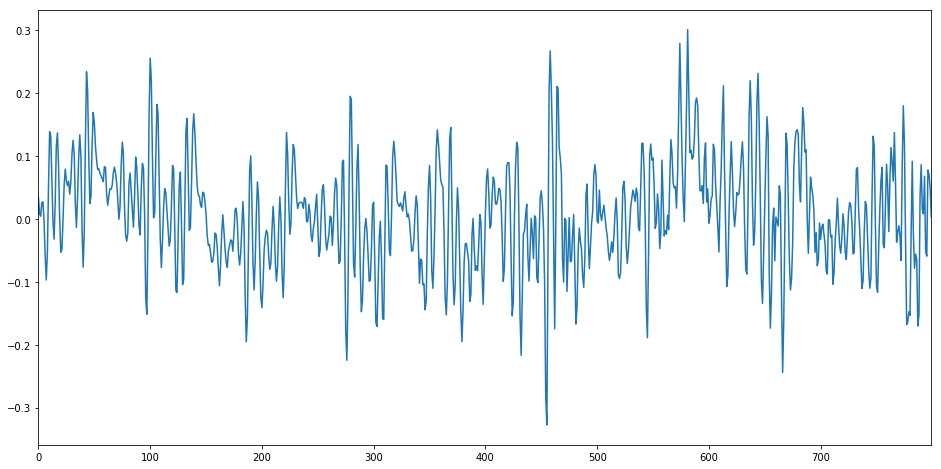

In [53]:
pd.Series(y_tr_n[:800]).plot.line(figsize=(16, 8))

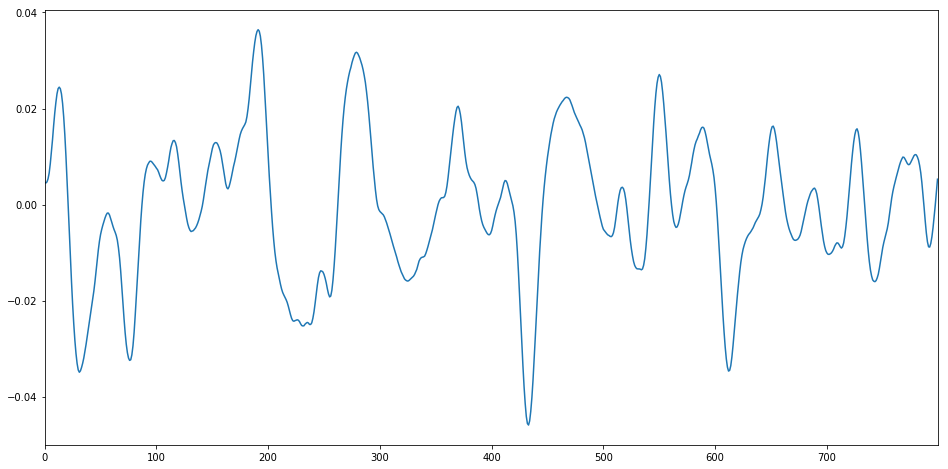

In [54]:
pd.Series(X_te_n[:800]).plot.line(figsize=(16, 8))

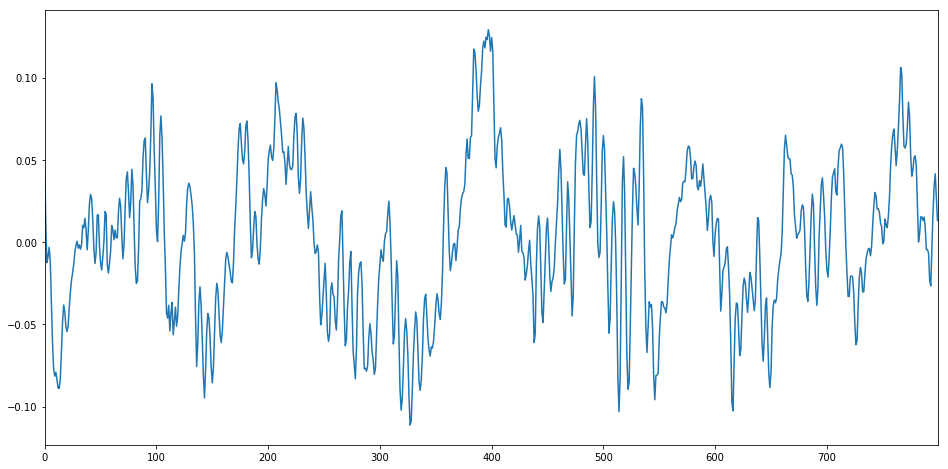

In [55]:
pd.Series(y_te_n[:800]).plot.line(figsize=(16, 8))

In [56]:
# appending stats of the whole sample, fading from silence

In [57]:
# train_shuffle_index = np.random.shuffle(np.arange(0, len(X_tr_n)))
# test_shuffle_index = np.random.shuffle(np.arange(0, len(X_te_n)))

# X_tr_f = X_tr_n[train_shuffle_index][0]
# y_tr_f = y_tr_n[train_shuffle_index][0]

# X_te_f = X_te_n[test_shuffle_index][0]
# y_te_f = y_te_n[test_shuffle_index][0]

## Making windows

In [58]:
# N_WINDOW_POINTS = int(source_clean_fs * 0.02)
N_WINDOW_POINTS = 100
N_WINDOW_POINTS

100

In [59]:
def make_windows(X, y, n_window_points):
    X_index = X.index
    index = 0
    
    res_X = []
    res_y = []

    for index in range(0, len(X) - n_window_points - 1):
        res_X.append(X.iloc[index:(index + n_window_points)])
        res_y.append(y.iloc[index + n_window_points])

    return (np.array(res_X), np.array(res_y))

In [60]:
(X_tr_f, y_tr_f) = make_windows(pd.Series(X_tr_n), pd.Series(y_tr_n), N_WINDOW_POINTS)
(len(X_tr_f), y_tr_n[64], y_tr_f[0])

(88099, 0.047975097, 0.2555315)

In [61]:
(X_te_f, y_te_f) = make_windows(pd.Series(X_te_n), pd.Series(y_te_n), N_WINDOW_POINTS)
(len(X_te_f), y_te_n[64], y_te_f[0])

(5962, 0.0026551103, 0.007141331)

In [62]:
# X_tr_f = X_tr_n
# y_tr_f = y_tr_n

# X_te_f = X_te_n
# y_te_f = y_te_n

In [63]:
(len(X_tr_f), len(y_tr_f), len(X_te_f), len(y_te_f))

(88099, 88099, 5962, 5962)

In [64]:
# list(map(lambda row: row[:N_PEAKS*2], X_tr_f))[0]
# # list(map(lambda row: row[:N_PEAKS], X_tr_f))[0]

<Figure size 1368x1080 with 0 Axes>

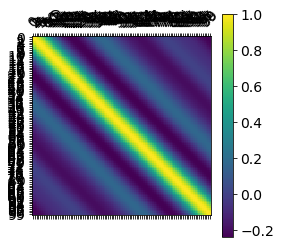

In [65]:
from matplotlib import pyplot as plt

# amp_df = pd.DataFrame(list(map(lambda row: row[N_PEAKS:N_PEAKS*2], X_tr_f)))
amp_df = pd.DataFrame(list(map(lambda row: row, X_tr_f)))

f = plt.figure(figsize=(19, 15))
plt.matshow(amp_df.corr())
plt.xticks(range(amp_df.shape[1]), amp_df.columns, fontsize=14, rotation=45)
plt.yticks(range(amp_df.shape[1]), amp_df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

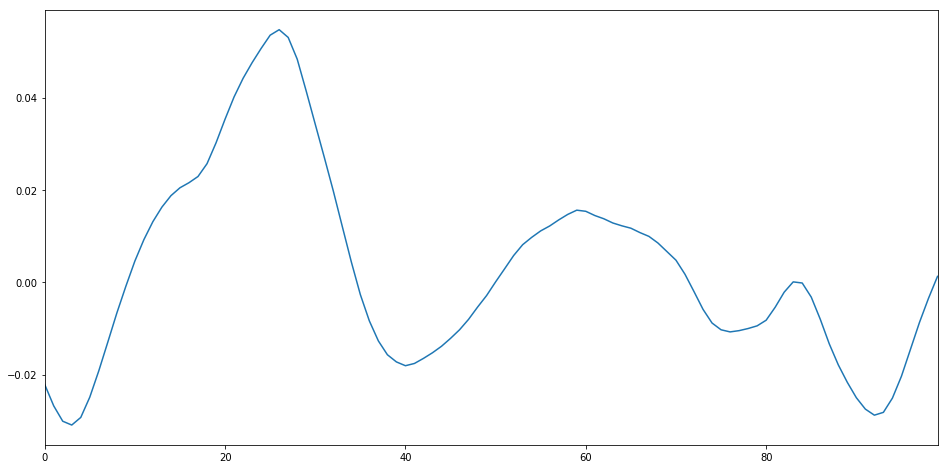

In [66]:
pd.Series(X_tr_f[0]).plot.line(figsize=(16, 8))

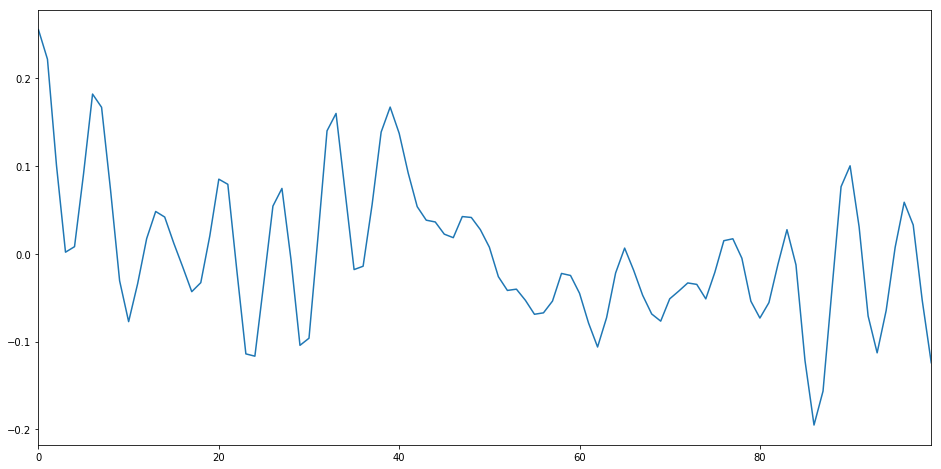

In [67]:
pd.Series(y_tr_f[:100]).plot.line(figsize=(16, 8))

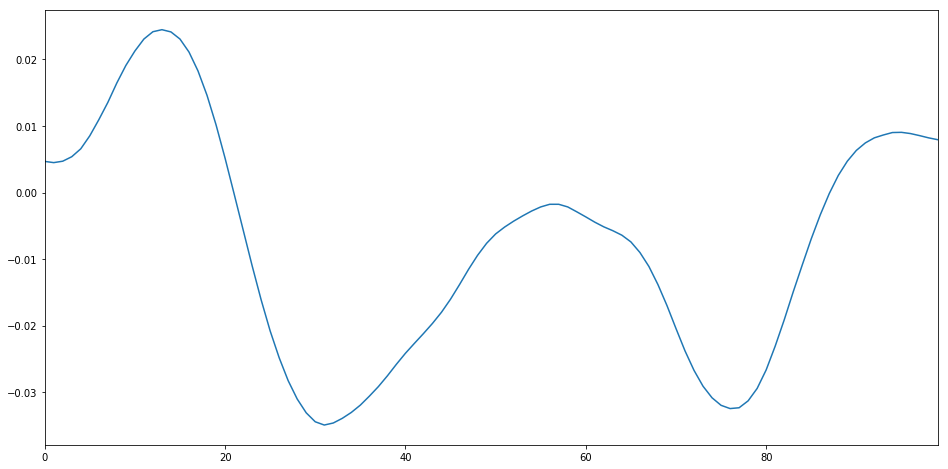

In [68]:
pd.Series(X_te_f[0]).plot.line(figsize=(16, 8))

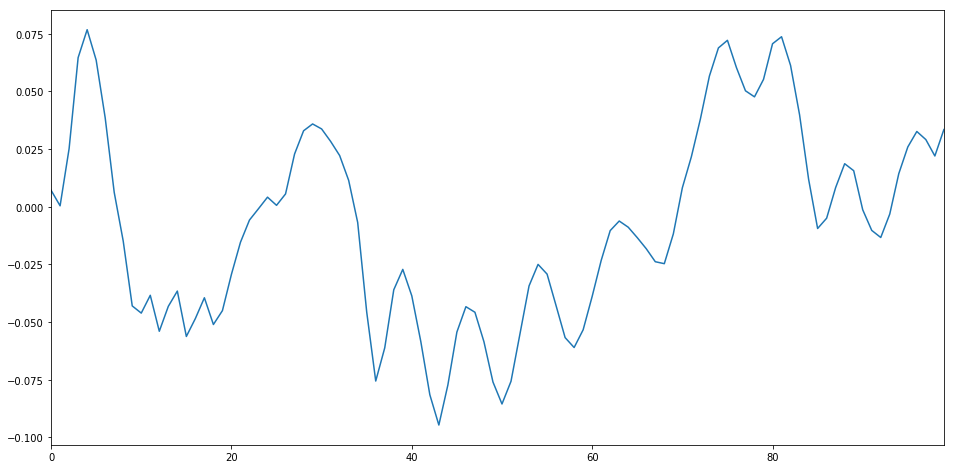

In [69]:
pd.Series(y_te_f[:100]).plot.line(figsize=(16, 8))

In [70]:
n_features = 1

In [71]:
(X_tr_f[0], y_tr_f[0])

(array([-2.21259203e-02, -2.67647337e-02, -3.00912503e-02, -3.09152510e-02,
        -2.92672515e-02, -2.48725861e-02, -1.91656239e-02, -1.29398480e-02,
        -6.65303506e-03, -8.54518265e-04,  4.60829493e-03,  9.24710836e-03,
         1.31534776e-02,  1.62968840e-02,  1.87688842e-02,  2.04779208e-02,
         2.15765871e-02,  2.29194015e-02,  2.56965850e-02,  3.02133244e-02,
         3.53404358e-02,  4.01623584e-02,  4.41908017e-02,  4.75783572e-02,
         5.06607257e-02,  5.35294674e-02,  5.47196865e-02,  5.30411713e-02,
         4.83413190e-02,  4.14136164e-02,  3.42417695e-02,  2.71004364e-02,
         1.98065136e-02,  1.20853297e-02,  4.42518387e-03, -2.65511032e-03,
        -8.36207159e-03, -1.26956999e-02, -1.56865139e-02, -1.72429588e-02,
        -1.80669576e-02, -1.75786614e-02, -1.64799951e-02, -1.52592547e-02,
        -1.38554033e-02, -1.21463668e-02, -1.02847377e-02, -8.02636798e-03,
        -5.37125766e-03, -2.86873989e-03,  9.15555283e-05,  2.92977691e-03,
         5.7

In [72]:
X_tr_s = X_tr_f.reshape(X_tr_f.shape[0], X_tr_f.shape[1], n_features)
X_tr_s[0]

array([[-2.21259203e-02],
       [-2.67647337e-02],
       [-3.00912503e-02],
       [-3.09152510e-02],
       [-2.92672515e-02],
       [-2.48725861e-02],
       [-1.91656239e-02],
       [-1.29398480e-02],
       [-6.65303506e-03],
       [-8.54518265e-04],
       [ 4.60829493e-03],
       [ 9.24710836e-03],
       [ 1.31534776e-02],
       [ 1.62968840e-02],
       [ 1.87688842e-02],
       [ 2.04779208e-02],
       [ 2.15765871e-02],
       [ 2.29194015e-02],
       [ 2.56965850e-02],
       [ 3.02133244e-02],
       [ 3.53404358e-02],
       [ 4.01623584e-02],
       [ 4.41908017e-02],
       [ 4.75783572e-02],
       [ 5.06607257e-02],
       [ 5.35294674e-02],
       [ 5.47196865e-02],
       [ 5.30411713e-02],
       [ 4.83413190e-02],
       [ 4.14136164e-02],
       [ 3.42417695e-02],
       [ 2.71004364e-02],
       [ 1.98065136e-02],
       [ 1.20853297e-02],
       [ 4.42518387e-03],
       [-2.65511032e-03],
       [-8.36207159e-03],
       [-1.26956999e-02],
       [-1.5

In [73]:
y_tr_s = y_tr_f

In [74]:
X_te_s = X_te_f.reshape(X_te_f.shape[0], X_te_f.shape[1], n_features)
X_te_s[0]

array([[ 0.00466933],
       [ 0.00448622],
       [ 0.00469985],
       [ 0.00537126],
       [ 0.00656148],
       [ 0.00851466],
       [ 0.01092563],
       [ 0.0135197 ],
       [ 0.01644948],
       [ 0.01907407],
       [ 0.02124088],
       [ 0.02304148],
       [ 0.02414014],
       [ 0.02444533],
       [ 0.02410962],
       [ 0.02304148],
       [ 0.02108829],
       [ 0.01825007],
       [ 0.01458785],
       [ 0.01016266],
       [ 0.00515763],
       [-0.00018311],
       [-0.00558489],
       [-0.01098666],
       [-0.01611377],
       [-0.02078311],
       [-0.02481155],
       [-0.02826014],
       [-0.03100681],
       [-0.03308206],
       [-0.03442488],
       [-0.03491317],
       [-0.03460799],
       [-0.03390606],
       [-0.03302103],
       [-0.03192236],
       [-0.03057955],
       [-0.02914518],
       [-0.0275277 ],
       [-0.02578814],
       [-0.02414014],
       [-0.02264473],
       [-0.02117985],
       [-0.01965392],
       [-0.0179754 ],
       [-0

In [75]:
y_te_s = y_te_f

## Finished data processing!

## Moving on to training NN

In [76]:
import numpy as np

In [77]:
# num_steps=100, 24 hidden states

In [78]:
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, Reshape, GRU, GaussianNoise
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.regularizers import L1L2

tf.set_random_seed(1234)

In [79]:
X_tr_s.shape, y_tr_s.shape, X_te_s.shape, y_te_s.shape

((88099, 100, 1), (88099,), (5962, 100, 1), (5962,))

In [80]:
y_tr_s

array([ 0.2555315 ,  0.22186956,  0.10080264, ..., -0.09732353,
        0.03778192,  0.10785241], dtype=float32)

In [81]:
from keras import backend as K
from keras.layers import Layer

class DebugLayer(Layer):

    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(DebugLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        super(DebugLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        print(x[0])
        return x

In [113]:
N_UNITS = 4
n_features = 1
BATCH_SIZE = 500

model = Sequential()

# model.add(LSTM(
#      10,
#      activation='relu',
#      stateful=True,
#      reset_after=True,
#      input_shape=(n_steps, n_features),
#      batch_input_shape=(1, n_steps, 1)
# ))

def loss(y_true,y_pred):
        return K.mean(K.square(y_pred - y_true) + K.square(layer), axis=-1)
    
model.add(GRU(
          N_UNITS,
          input_shape=(N_WINDOW_POINTS, n_features),
          # bias_regularizer=L1L2(l1=0.01, l2=0.01),
          stateful=True,
          # reset_after=True,
          # recurrent_activation='sigmoid',
          batch_input_shape=(BATCH_SIZE, N_WINDOW_POINTS, n_features),
          return_sequences=True,
))

model.add(GRU(
          N_UNITS,
          input_shape=(N_WINDOW_POINTS, n_features),
          # bias_regularizer=L1L2(l1=0.01, l2=0.01),
          stateful=True,
          # reset_after=True,
          # recurrent_activation='sigmoid',
          batch_input_shape=(BATCH_SIZE, N_WINDOW_POINTS, n_features),
          # return_sequences=True
))

# model.add(GRU(
#           N_UNITS,
#           input_shape=(N_WINDOW_POINTS, n_features),
#           # bias_regularizer=L1L2(l1=0.01, l2=0.01),
#           # stateful=True,
#           # reset_after=True,
#           # recurrent_activation='sigmoid',
# ))
          # return_sequences=True))

# model.add(GaussianNoise(0.01))

model.add(Dense(1))

optimizer = keras.optimizers.adam(lr=0.2)
# optimizer = keras.optimizers.SGD(lr=0.1, decay=0.2)

model.compile(optimizer=optimizer, loss='mae')

In [114]:
# with K.tf.device('/device:GPU:0'):
#     config = tf.ConfigProto(
#              intra_op_parallelism_threads=4,\
#              inter_op_parallelism_threads=4, allow_soft_placement=True,\
#              device_count = {'CPU' : 1, 'GPU' : 1},
#              log_device_placement=True)
#     K.set_session(session)

In [115]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [116]:
%%time

# TRAIN

N_SAMPLES = 80000
# N_SAMPLES = 8800
# N_SAMPLES = 100

history = model.fit(X_tr_s[:N_SAMPLES], y_tr_s[:N_SAMPLES], batch_size=BATCH_SIZE, epochs=2, verbose=1, validation_split=0.2)

Train on 64000 samples, validate on 16000 samples
Epoch 1/2
64000/64000 [==============================] - 35s 544us/step - loss: 0.0821 - val_loss: 0.1426
Epoch 2/2
64000/64000 [==============================] - 34s 526us/step - loss: 0.0786 - val_loss: 0.1424
CPU times: user 1min 52s, sys: 20.3 s, total: 2min 13s
Wall time: 1min 9s


In [ ]:
for layer in model.layers:
    weights = layer.get_weights() # list of numpy arrays
    print(weights)
    print('='*20)

In [ ]:
model.summary()

In [ ]:
score = model.evaluate(X_te_s[:500], y_te_s[:500], verbose=0, batch_size=BATCH_SIZE)
score

In [ ]:
0.002701892083277926

In [ ]:
from matplotlib import pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

In [ ]:
len(X_te_f)

In [98]:
import math

def predict(model, rows):
    X_input = np.array(rows).reshape(rows.shape[0], rows.shape[1], 1)
    
    return np.array(
        model.predict(
            X_input[:(math.floor(len(rows) / BATCH_SIZE) * BATCH_SIZE)], batch_size=BATCH_SIZE
        )
    ).flatten()

In [99]:
predict(model, X_te_f[:10])

array([], dtype=float64)

0   -0.469664
1   -0.349153
2   -0.151483
3   -0.072118
4    0.074210
dtype: float32


Text(0, 0.5, 'value')

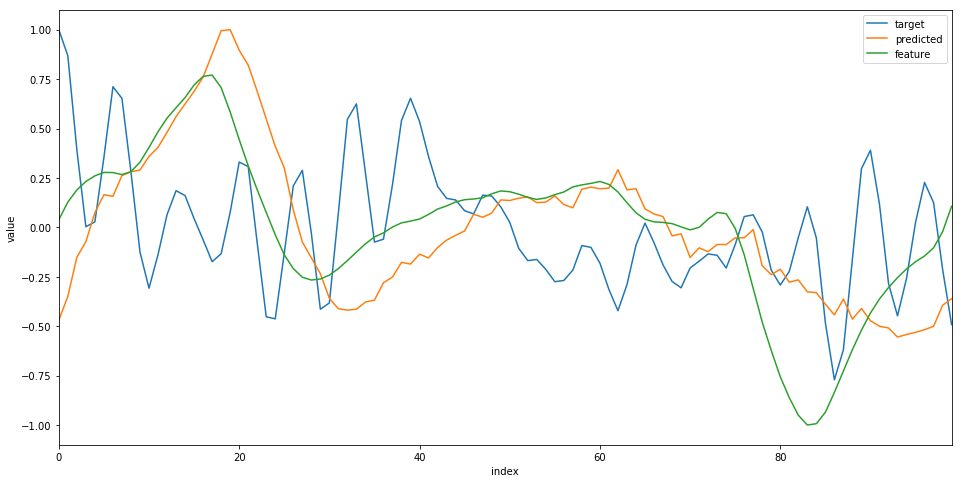

In [112]:
from scipy.signal import savgol_filter

(fig, ax) = plt.subplots(figsize=(16, 8))

I = 500
N = 100

(pd.Series(normalize(y_tr_f[:N]))).plot.line(ax=ax, label='target')

pred = pd.Series(predict(model, X_tr_f[:I])).iloc[:N]
pred = normalize(pred)

print(pred[:5])

pred.plot.line(ax=ax, label='predicted')

pd.Series(normalize(np.array(list(map(lambda w: w[-1], X_tr_f[:N]))))).plot.line(ax=ax, label='feature')

# pd.Series(savgol_filter(pred, 5, 3)).plot.line(ax=ax, label='savgol(predicted)')

ax.legend(loc="upper right")
ax.set_xlabel('index')
ax.set_ylabel('value')

## Time to evaluate performance

In [ ]:
predictions = predict(model, X_tr_f[:10000])
len(predictions), predictions[:10]

In [ ]:
wavfile.write('output/clean_train_pred_out.wav', source_clean_fs, predictions)

In [ ]:
len(predictions)